# Generate data

In [36]:
%load_ext autoreload
%autoreload 2

import numpy as np
from mlscratch.softmax_regression import SoftmaxRegression
from mlscratch.utils import train_test_split

# --- Reproducibility ---
rng = np.random.default_rng(0)

# --- Dataset parameters ---
n_data = 100
c1, c2, c3 = [0, 0], [3, 3], [0, 4]
sigma = np.array([[0.5, 0],
                  [0, 0.5]])   # covariance (symmetric, PD)

# --- Generate Gaussian clusters ---
X1 = rng.multivariate_normal(c1, sigma, size=n_data)
X2 = rng.multivariate_normal(c2, sigma, size=n_data)
X3 = rng.multivariate_normal(c3, sigma, size=n_data)

y1 = np.zeros(n_data, dtype=np.int64)
y2 = np.ones(n_data, dtype=np.int64)
y3 = np.ones(n_data, dtype=np.int64) * 5   # intentionally non-contiguous label

X = np.r_[X1, X2, X3]
y = np.r_[y1, y2, y3]

# --- Train/test split (80/20) ---
X_train, y_train, X_test, y_test = train_test_split(X, y)

# --- Train model ---
model = SoftmaxRegression()
model.fit(X_train, y_train, lr=0.1, max_iter=5000, tol=1e-6)

# --- Evaluate ---
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Training accuracy: {train_score:.3f}")
print(f"Test accuracy:     {test_score:.3f}")
print(f"Classes learned:   {model.classes_}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training accuracy: 0.996
Test accuracy:     0.983
Classes learned:   [0 1 5]


# Plot result

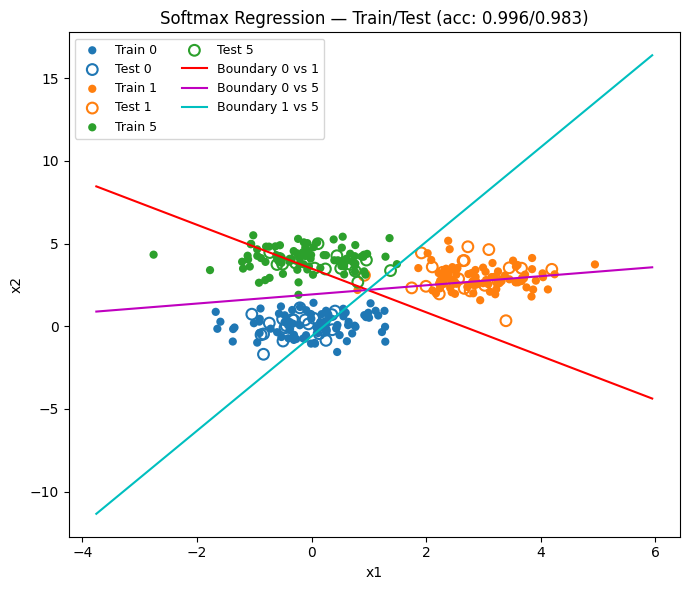

In [37]:
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt


# assumes you already have: model, X_train, y_train, X_test, y_test
coef = model.coef_             # (2, K)
intercept = model.intercept_   # (K,)
classes = model.classes_       # original labels, e.g. [0,1,5]
K = coef.shape[1]

# Colors per class (consistent & scalable)
cmap = plt.get_cmap("tab10")
class_to_color = {cls: cmap(i % 10) for i, cls in enumerate(classes)}

plt.figure(figsize=(7, 6))

# --- scatter: train (filled), test (hollow) ---
for cls in classes:
    m_train = (y_train == cls)
    m_test  = (y_test  == cls)
    # train = filled
    plt.scatter(X_train[m_train, 0], X_train[m_train, 1],
                s=35, c=[class_to_color[cls]], edgecolors="none",
                label=f"Train {cls}")
    # test = hollow (edge colored)
    plt.scatter(X_test[m_test, 0],  X_test[m_test, 1],
                s=60, facecolors="none", edgecolors=[class_to_color[cls]],
                linewidths=1.5, label=f"Test {cls}")

# --- pairwise decision boundaries s_i(x)=s_j(x) ---
X_all = np.vstack([X_train, X_test])
x_min, x_max = X_all[:, 0].min() - 1.0, X_all[:, 0].max() + 1.0
x = np.linspace(x_min, x_max, 500)
eps = 1e-12

# distinct boundary line colors
line_colors = ["r", "m", "c", "k", "orange", "purple", "brown", "olive", "teal"]
for idx, (i, j) in enumerate(combinations(range(K), 2)):
    dw = coef[:, i] - coef[:, j]           # (2,)
    db = intercept[i] - intercept[j]       # scalar
    w1, w2 = dw
    color = line_colors[idx % len(line_colors)]
    label = f"Boundary {classes[i]} vs {classes[j]}"
    if abs(w2) > eps:
        y_boundary = -(w1 / w2) * x - db / w2
        plt.plot(x, y_boundary, color=color, linewidth=1.5, label=label)
    elif abs(w1) > eps:
        x_boundary = -db / w1
        plt.axvline(x_boundary, color=color, linewidth=1.5, label=label)

# --- cosmetics ---
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
plt.title(f"Softmax Regression — Train/Test (acc: {train_acc:.3f}/{test_acc:.3f})")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(ncols=2, fontsize=9)
plt.tight_layout()
plt.show()
